In [1]:
import numpy as np
import pandas as pd
import torch 
import pytorch_lightning
from bicycle.model import BICYCLE
from pathlib import Path
import matplotlib.pyplot as plt
from evaluate import distance, above_threshold, get_sparsity
import json

In [2]:
save = True

In [9]:
def agg1(params, param_of_interest):
    params = params.sort_index()
    params["config"] = ["Vanilla", "Bayes prior", "Binary Prior"]
    param_of_interest = "config"
    return params, param_of_interest
def agg2(params, param_of_interest):
    params = params.sort_index()
    return params, param_of_interest
def agg3(params, param_of_interest):
    params = params.sort_index()
    params["Config"] = ["Vanilla\n5 TFs", "Masking loss\n5 TFs", "Vanilla\n10 TFs", "Masking loss\n10 TFs","Vanilla\n6 TFs", "Masking loss\n6 TFs"]
    params = params.iloc[[0,4,2,1,5,3]]
    param_of_interest = "Config"
    return params, param_of_interest
def agg4(params, param_of_interest):
    params = params.sort_index()
    params["Config"] = ["Vanilla\n400 Pert.", "Masking loss\n400 Pert.", "Masking loss\n200 Pert.", "Masking loss\n100 Pert.", "Vanilla\n200 Pert.", "Vanilla\n100 Pert."]
    param_of_interest = "Config"
    return params, param_of_interest
def agg5(params, param_of_interest):
    params = params.sort_index()
    if len(params)>4:
        params["pert. Strength"] = np.append([0],1/np.arange(4, 0,-1))
    else:
        params["pert. Strength"] = 1/np.arange(4, 0,-1)

    param_of_interest = "pert. Strength"
    return params, param_of_interest
def agg6(params, param_of_interest):
    params = params.sort_values(param_of_interest)
    params[param_of_interest] = params[param_of_interest].astype(float)
    return params, param_of_interest
functions = {
    "agg1":agg1,
    "agg2":agg2,
    "agg3":agg3,
    "agg4":agg4,
    "agg5":agg5,
    "agg6":agg6,
}

In [10]:
with open("./data/experiment_configs.json", "r") as rf:
    config_sets = json.load(rf)


In [11]:
# get environment
config_set = config_sets[2]
include = config_set["include"]
id_len = config_set["id_len"]
prefix = config_set["prefix"]
experiment = config_set["experiment"]
param_of_interest = config_set["param_of_interest"]

models_path = Path("/data/toulouse/bicycle/notebooks/experiments/masking/data/model_runs/models/")
plot_path = Path("/data/toulouse/bicycle/notebooks/experiments/masking/data/model_runs/plots")
columns = [
     "model_lr",
     "model_n_genes",
     "model_n_samples",
     "model_gt_interv",
    "pretraining_time",
    "training_time",
    "compile",
    "trad_loading",
    "scale_mask",
    "grn_noise_p",
    "n_epochs",
    "use_hard_mask",
    "masking_mode",
    "bin_prior",
    "data_id"
    ]
if not param_of_interest in columns:
    columns.append(param_of_interest)
params = pd.DataFrame(columns=columns)
for dir in plot_path.iterdir():
    if dir.name[:-id_len] != prefix:
         continue
    if int(dir.name[-id_len:]) not in include:
          continue
    print(dir.name)
    try:
        globs = pd.read_csv(dir/ "globals.csv", delimiter=",").set_index("0", drop=True).T
        available_paras = [n for n in columns if n in globs.columns]
        params.loc[dir.name] = globs[available_paras].iloc[1]
    except FileNotFoundError:
        print(f"globals file for {dir.name} not found!")
        params.loc[dir.name] = np.nan
if experiment == "scalemask":
     params = pd.read_csv(models_path.parent/"param1.csv", index_col=0).sort_values("scale_mask")
    
if config_set["function"] != None:
     params, param_of_interest = functions[config_set["function"]](params, param_of_interest)
#params1 = pd.read_csv(models_path.parent/"manual_params.csv", index_col=0).sort_index()
#add = "test_run_00025"
#available_paras=[n for n in params.columns if n in params1.columns]
#params.loc[add, available_paras] = params1.loc[add,available_paras]

ckpts = dict()
for path in models_path.iterdir():
    if path.name[:-id_len] != prefix:
         continue
    if int(path.name[-id_len:]) not in include:
          continue
    ckpt_path = path / "customcheckpoint/last-v1.ckpt"

    if not ckpt_path.exists():
        print("unsing last")
        ckpt_path = path / "customcheckpoint/last.ckpt"
        if not ckpt_path.exists():
            continue

    key = str(path.name)
    print(key)
    state = torch.load(ckpt_path, weights_only=False, map_location="cpu")
    print("last epoch: ",state["epoch"])
    if state["epoch"]<500:
         print(f"{key} only has {state['epoch']} epoch.\nWill be removed...")
         params = params.drop(index=key)
         continue
    ckpts[str(path.name)] = {}
    grn = state["hyper_parameters"]["gt_beta"]
    ckpts[str(path.name)]["grn"] = grn
    if not state["hyper_parameters"]["mask"] is None:
            beta = np.zeros(grn.shape)
            beta[state["hyper_parameters"]["mask"].to(bool)] = state["state_dict"]["beta_val"].numpy()
            ckpts[str(path.name)]["beta"] = beta
    else:
        ckpts[str(path.name)]["beta"] = state["state_dict"]["beta"].numpy()
    prior = state["hyper_parameters"].get("bayes_prior", None)
    if not prior is None:
        ckpts[str(path.name)]["prior"] = prior.numpy()


run_001
run_011
run_000
run_001
last epoch:  9999
run_011
last epoch:  5497
run_000
last epoch:  9999


Saving!


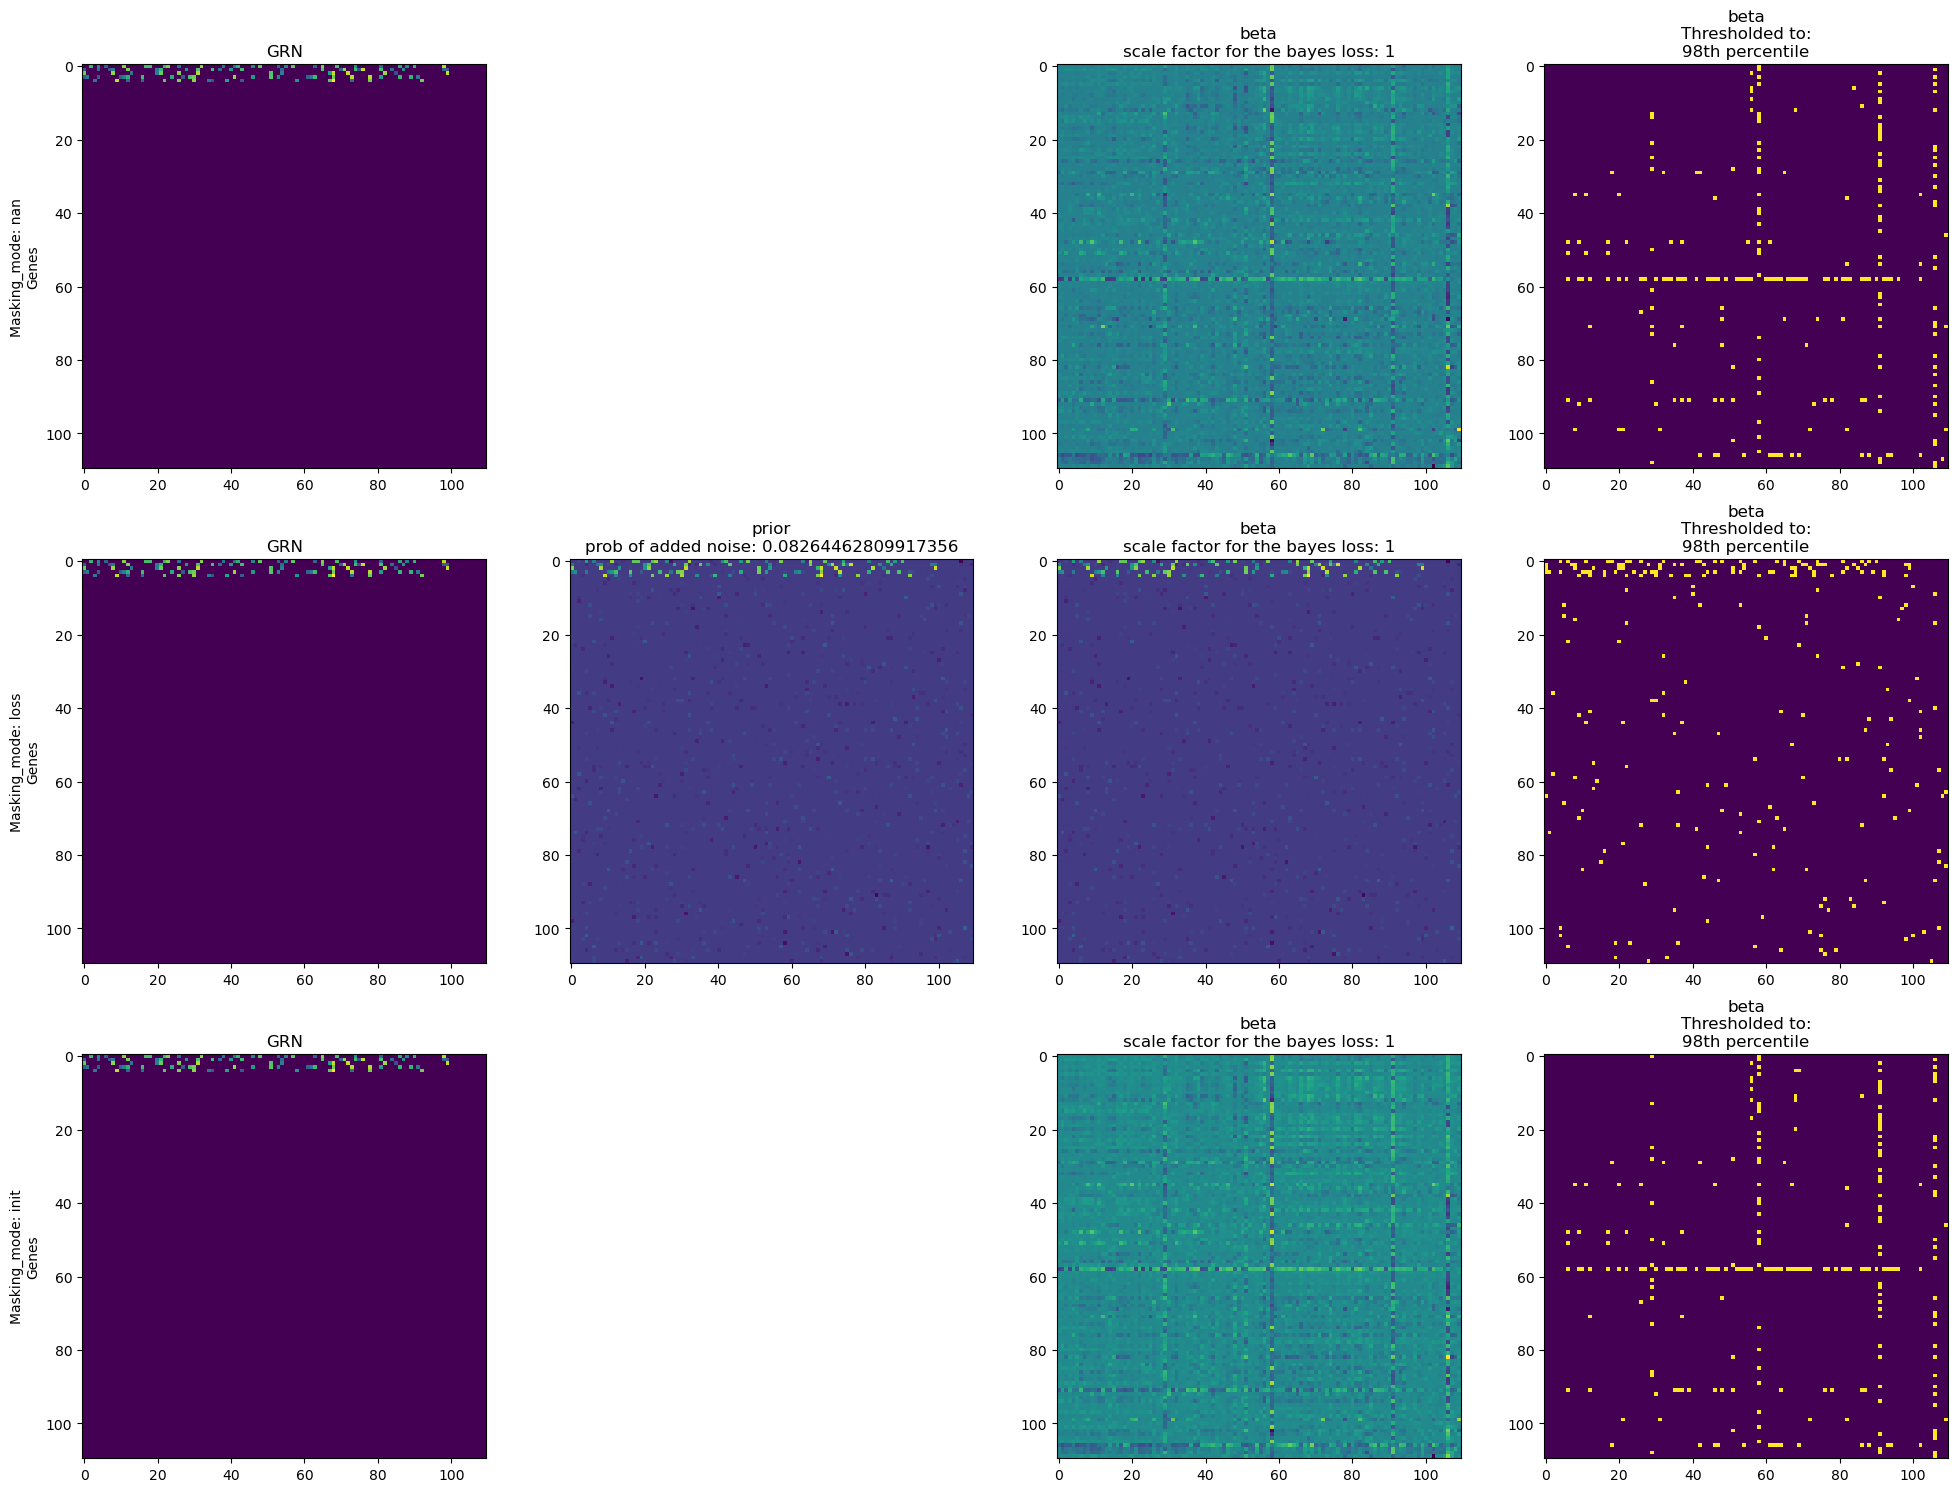

In [25]:
hists = False
h=1
if hists:
    h=2
fig, ax = plt.subplots(nrows=1 *len(params), ncols=4, figsize=(20, 5*1*len(params)), squeeze=True)


threshold_sparcity = False
for n, key in enumerate(params.index):
    ax[0+n*h, 0].imshow(ckpts[key]["grn"])

    ax[0+n*h, 0].set_title("GRN")
    if not param_of_interest == "grn_noise_p":
        if not type(params.loc[key,param_of_interest]) is str:
            ax[0+n*h, 0].set_ylabel(f"{param_of_interest.capitalize()}: {np.round(params.loc[key, param_of_interest], 3).astype(str)}\nGenes")
        else:
            ax[0+n*h, 0].set_ylabel(f"{param_of_interest.capitalize()}: {params.loc[key, param_of_interest]}\nGenes")
    
    ax[0+n*h, 0].set_title("GRN")
    if hists:
        ax[1+n*h, 0].hist(ckpts[key]["grn"])
    if "prior" in ckpts[key].keys():
        ax[0+n*h, 1].imshow(ckpts[key]["prior"])
        
        
        ax[0+n*h, 1].set_title("prior\nprob of added noise: "+str(params.loc[key, "grn_noise_p"]))
        if hists:
            ax[1+n*h, 1].hist(ckpts[key]["prior"])
        if threshold_sparcity:
            threshold_sparcity = "prior"
    else:
        fig.delaxes(ax[0+n*h, 1])
        if hists:
            fig.delaxes(ax[1+n*h, 1])
        if threshold_sparcity:
            threshold_sparcity = "grn"

    ax[0+n*h, 2].imshow(ckpts[key]["beta"])
    
    
    ax[0+n*h, 2].set_title("beta\nscale factor for the bayes loss: "+str(params.loc[key, "scale_mask"]))
    if hists:
        ax[1+n*h, 2].hist(ckpts[key]["beta"])

    if threshold_sparcity:
        threshold = 100-get_sparsity(ckpts[key][threshold_sparcity])*100
        ax[0+n*h, 3].set_title(f"beta\nThresholded to {threshold_sparcity} sparcity:\n{str(np.round(threshold, 3))}th percentile")
    else:
        threshold = 98
        ax[0+n*h, 3].set_title(f"beta\nThresholded to:\n{str(threshold)}th percentile")

    mtx=above_threshold(np.array(ckpts[key]["beta"]), percentile=threshold)
    ax[0+n*h, 3].imshow(mtx)
    
    
    if hists:
        ax[1+n*h, 3].hist(mtx)



fig.tight_layout()
if save:
    print("Saving!")
    fig.savefig(f"./presentation/{experiment}_beta_tableau.pdf", bbox_inches = "tight", pad_inches = 0)
else:
    fig.show()

Saving!


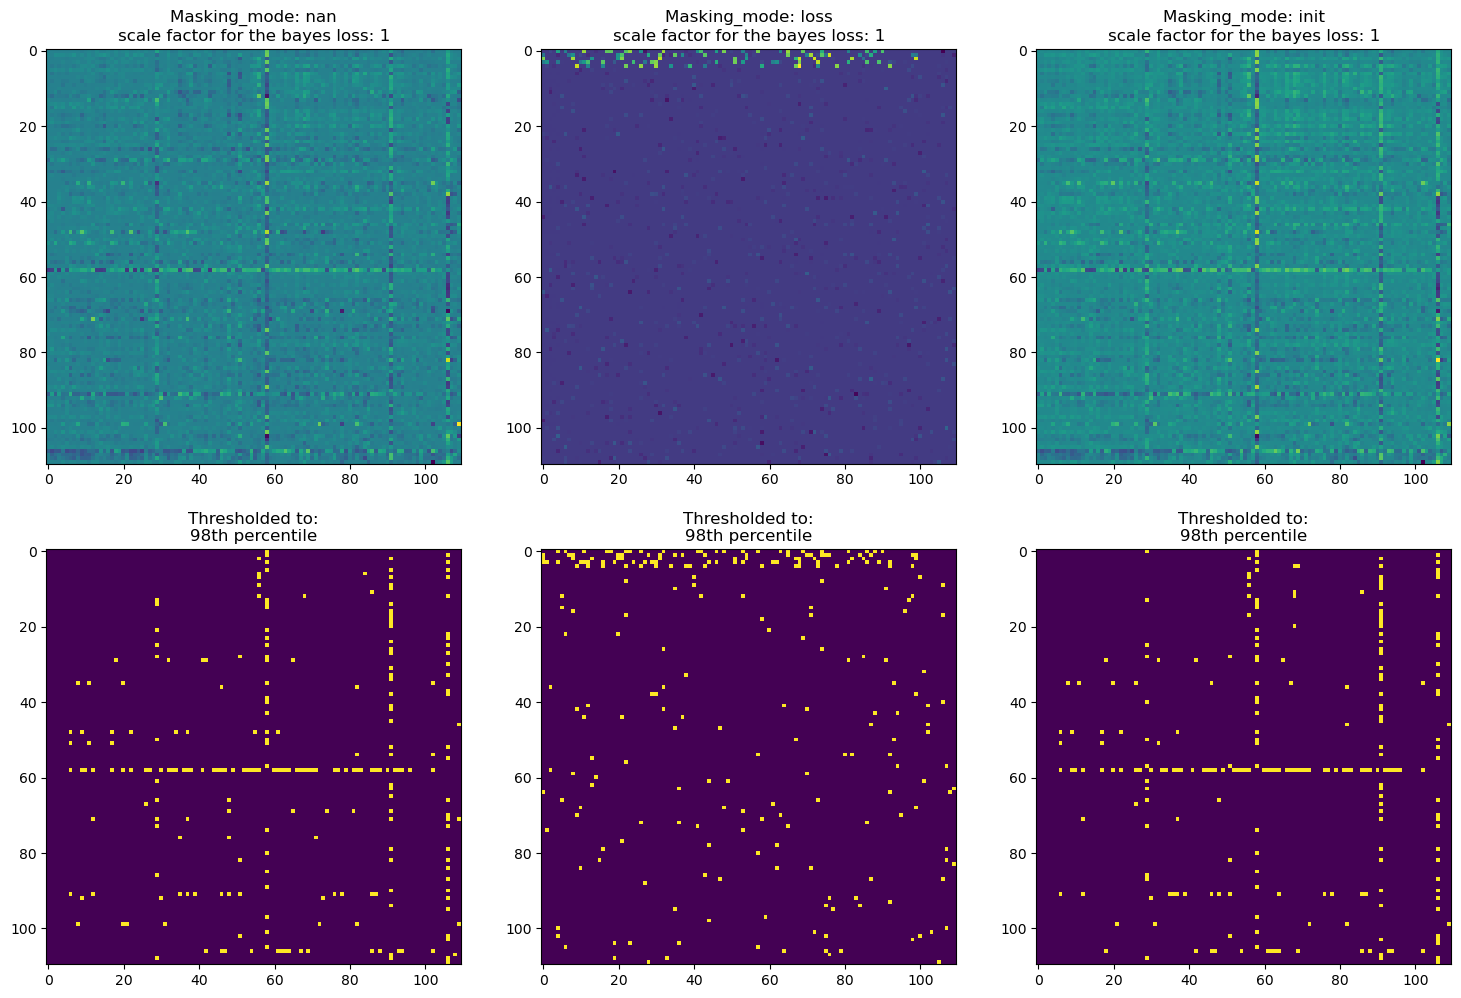

In [26]:
fig, ax = plt.subplots(ncols=1 *len(params), nrows=2, figsize=(5*len(params), 10), squeeze=True)


threshold_sparcity = False
for n, key in enumerate(params.index):
    if not param_of_interest == "grn_noise_p":
        if not type(params.loc[key,param_of_interest]) is str:
            title = f"{param_of_interest.capitalize()}: {np.round(params.loc[key, param_of_interest], 3).astype(str)}"
        else:
            title = f"{param_of_interest.capitalize()}: {params.loc[key, param_of_interest]}"
    
    if "prior" in ckpts[key].keys():        
        if threshold_sparcity:
            threshold_sparcity = "prior"
    else:
        if threshold_sparcity:
            threshold_sparcity = "grn"

    ax[0, n].imshow(ckpts[key]["beta"])
    
    
    ax[0, n].set_title(f"{title}\nscale factor for the bayes loss: "+str(params.loc[key, "scale_mask"]))
    

    if threshold_sparcity:
        threshold = 100-get_sparsity(ckpts[key][threshold_sparcity])*100
        ax[1, n].set_title(f"\nThresholded to {threshold_sparcity} sparcity:\n{str(np.round(threshold, 3))}th percentile")
    else:
        threshold = 98
        ax[1, n].set_title(f"\nThresholded to:\n{str(threshold)}th percentile")

    mtx=above_threshold(np.array(ckpts[key]["beta"]), percentile=threshold)
    ax[1, n].imshow(mtx)
    
    
    



fig.tight_layout()
if save:
    print("Saving!")
    fig.savefig(f"./presentation/{experiment}_beta.pdf", bbox_inches = "tight", pad_inches = 0)
else:
    fig.show()

## mask vs no mask - maskloss

In [85]:
# get environment
include = np.arange(32, 34)
plot_path = Path("/data/toulouse/bicycle/notebooks/experiments/masking/data/model_runs/plots")
columns = [
    "pretraining_time",
    "training_time",
    "compile",
    "trad_loading",
    "scale_mask",
    "grn_noise_p",
    "n_epochs",
    "masking_mode"
    ]
params = pd.DataFrame(columns=columns)
for dir in plot_path.iterdir():
    if int(dir.name[-5:]) not in include:
          continue
    try:
        globs = pd.read_csv(dir/ "globals.csv", delimiter=",").set_index("0", drop=True).T
        available_paras = [n for n in columns if n in globs.columns]
        params.loc[dir.name] = globs[available_paras].iloc[1]
    except FileNotFoundError:
        print(f"globals file for {dir.name} not found!")
params = params.sort_values("scale_mask")

models_path = Path("/data/toulouse/bicycle/notebooks/experiments/masking/data/model_runs/models/")
ckpts = dict()
previous_key = None
for path in models_path.iterdir():
    
    if int(path.name[-5:]) not in include:
          continue
    ckpt_path = path / "customcheckpoint/last.ckpt"

    if not ckpt_path.exists():
        continue
    print(path.name)
    model = BICYCLE.load_from_checkpoint(ckpt_path).cpu()

    ckpts[str(path.name)] = {}
    with torch.no_grad():
        grn = model.gt_beta.copy()
        if not model.bayes_prior is None:
            ckpts[str(path.name)]["prior"] = model.bayes_prior.cpu().numpy().copy()
            if params.loc[str(path.name), "masking_mode"] == "loss":
                print("Using supplied grn")
                ckpts[str(path.name)]["grn"] = np.load(models_path.parent/"gt_grn.npy")
            else:
                ckpts[str(path.name)]["grn"] = grn
        else:
            ckpts[str(path.name)]["grn"] = grn
            
        if not model.mask is None:
            beta = np.zeros(grn.shape)
            beta[model.mask.cpu().to(bool)] = model.beta_val
            ckpts[str(path.name)]["beta"] = beta
            #plt.hist(beta)
            #plt.show()

        else:
            ckpts[str(path.name)]["beta"] = model.beta.detach().numpy().copy()
    previous_key = str(path.name)

params.head()

test_run_00032
Initializing parameters from data
test_run_00033
Initializing parameters from data
Using supplied grn


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/utilities/migration/utils.py:55: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.5.1.post0, which is newer than your current Lightning version: v2.0.9
  rank_zero_warn(


,pretraining_time,training_time,compile,trad_loading,scale_mask,grn_noise_p,n_epochs,masking_mode
test_run_00032,881.279972076416,21381.666881084442,True,True,0,NaN,10000,NaN
test_run_00033,833.4992616176605,19788.161154270172,True,True,1,0.005371900826446281,10000,loss


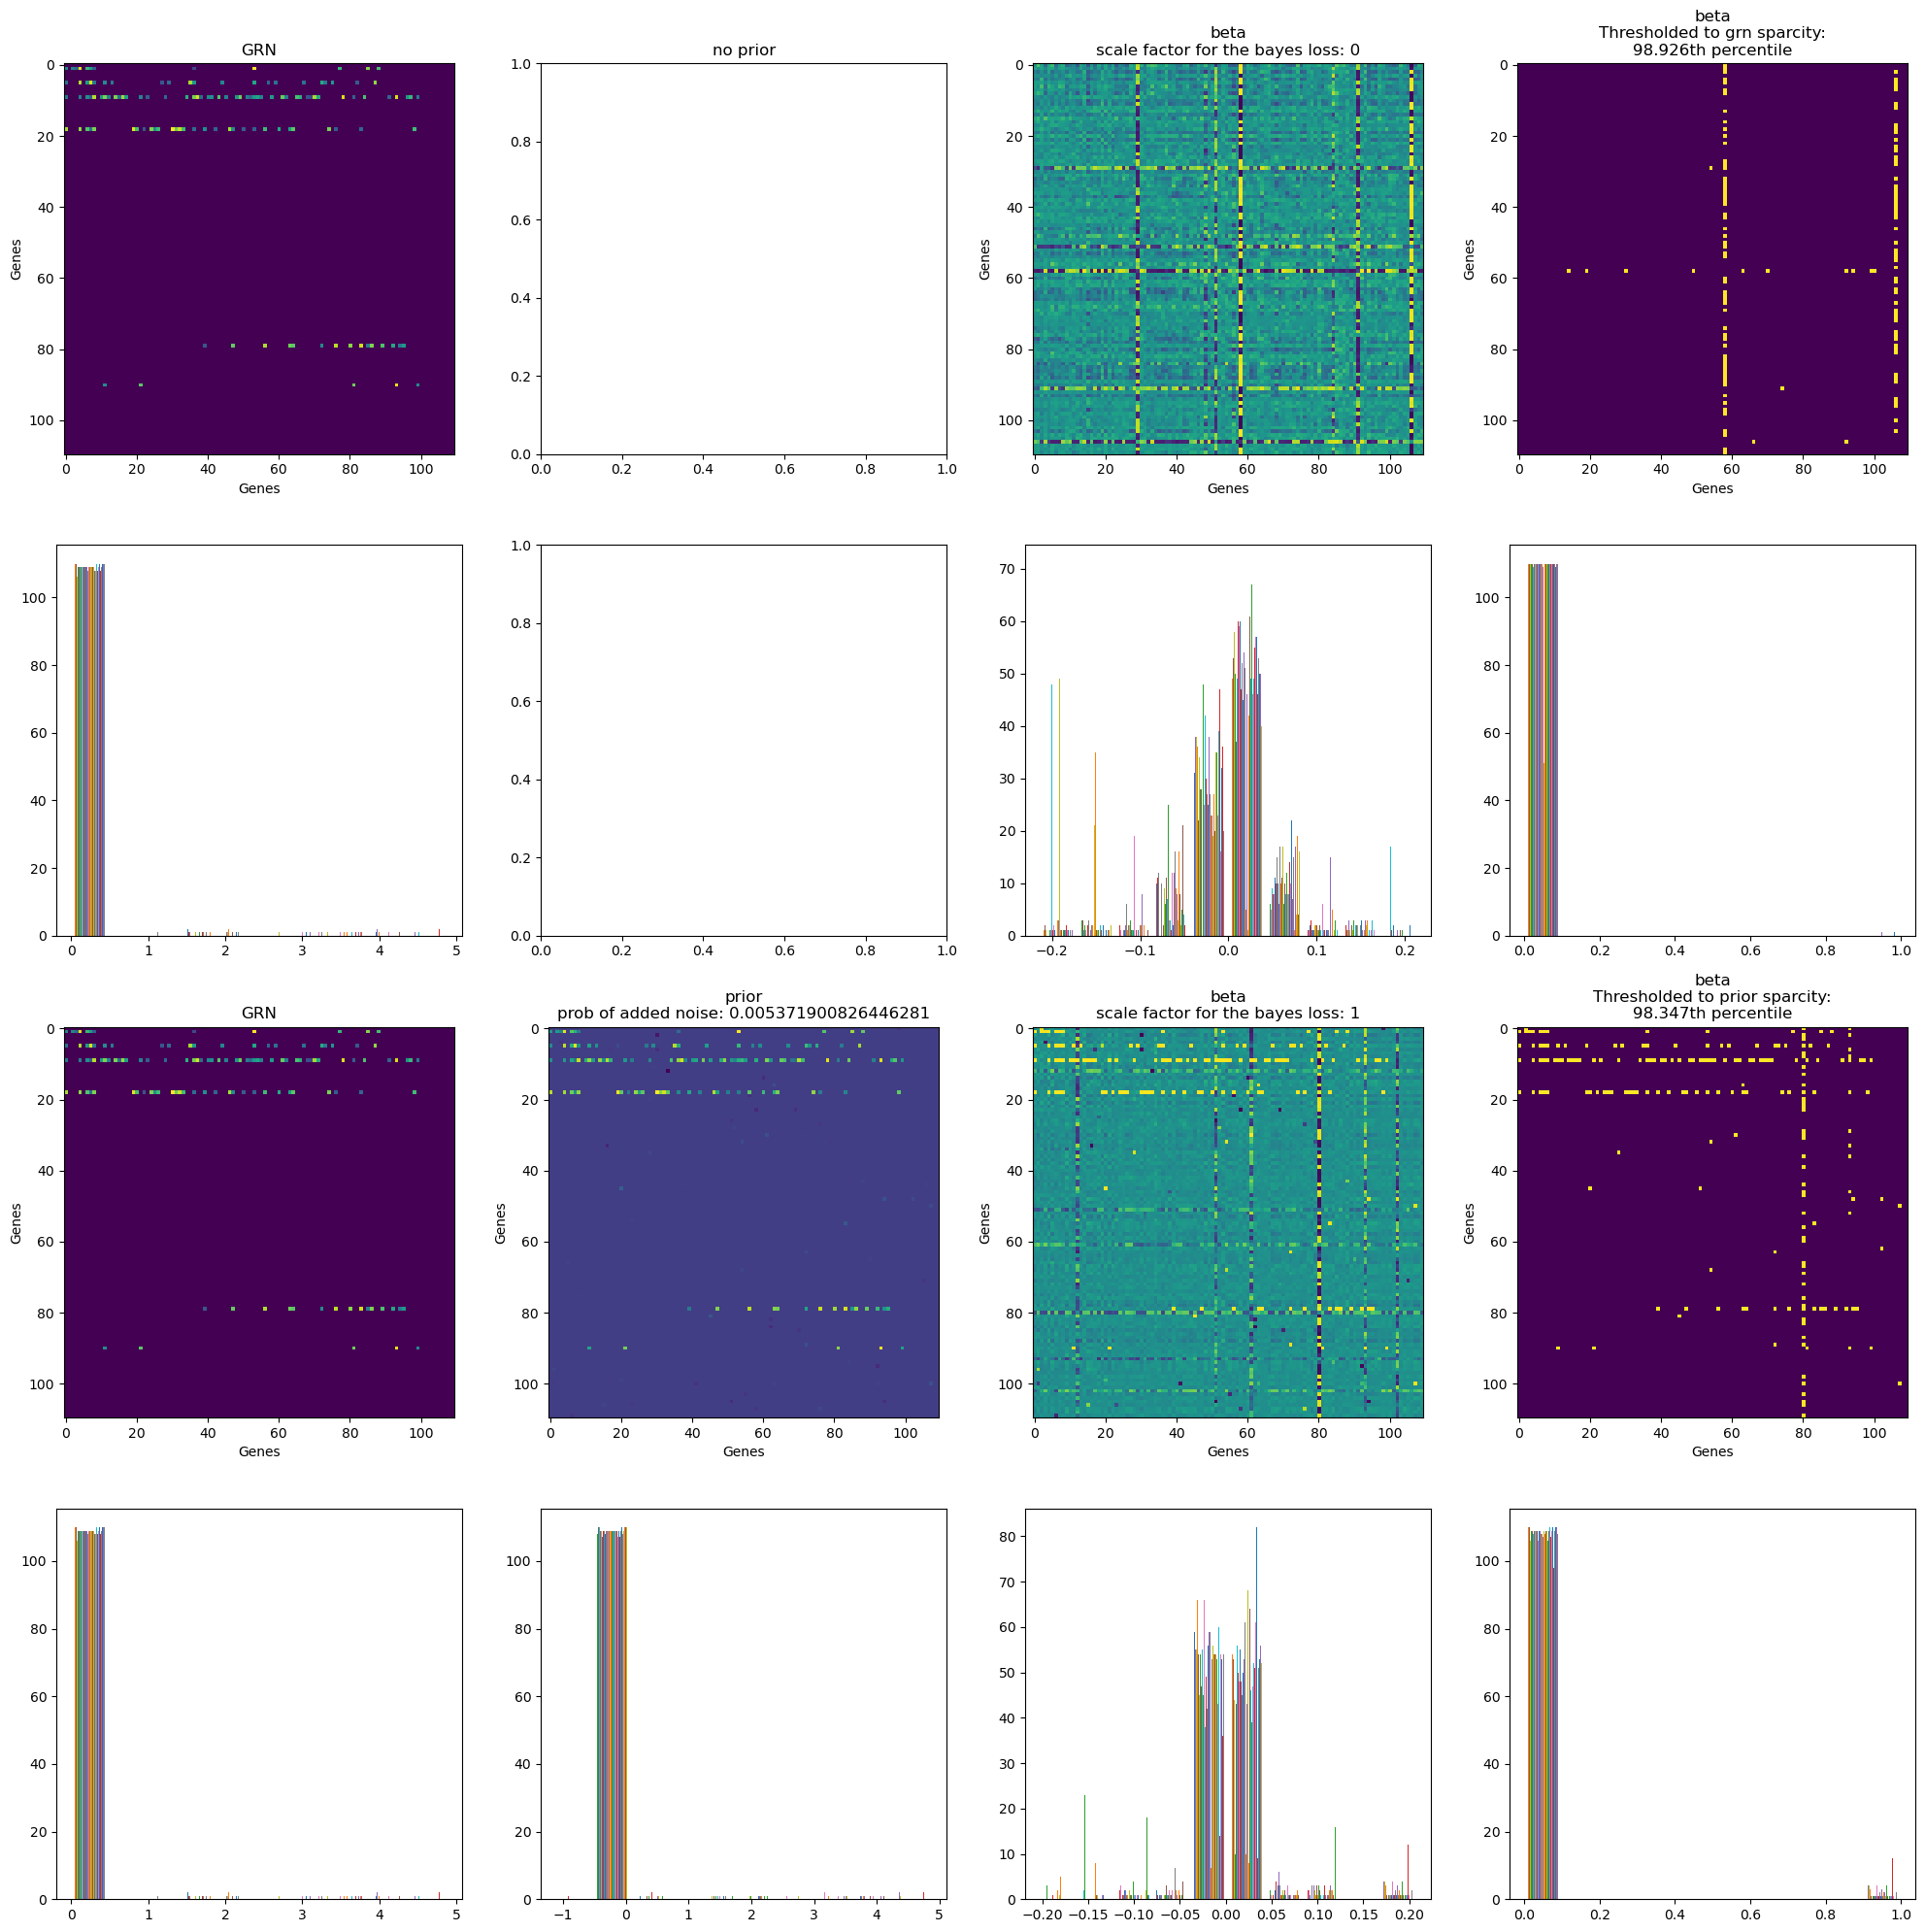

In [86]:

fig, ax = plt.subplots(nrows=2 *len(params), ncols=4, figsize=(20, 10*len(params)))
for n, key in enumerate(params.index):
    ax[0+n*2, 0].imshow(ckpts[key]["grn"])

    ax[0+n*2, 0].set_title("GRN")
    ax[0+n*2, 0].set_xlabel("Genes")
    ax[0+n*2, 0].set_ylabel("Genes")
    ax[0+n*2, 0].set_title("GRN")
    ax[1+n*2, 0].hist(ckpts[key]["grn"])
    if "prior" in ckpts[key].keys():
        ax[0+n*2, 1].imshow(ckpts[key]["prior"])
        ax[0+n*2, 1].set_ylabel("Genes")
        ax[0+n*2, 1].set_xlabel("Genes")
        ax[0+n*2, 1].set_title("prior\nprob of added noise: "+str(params.loc[key, "grn_noise_p"]))
        ax[1+n*2, 1].hist(ckpts[key]["prior"])
        threshold_sparcity = "prior"

    else:
        ax[0+n*2, 1].set_title("no prior")
        threshold_sparcity = "grn"        


    ax[0+n*2, 2].imshow(ckpts[key]["beta"])
    ax[0+n*2, 2].set_ylabel("Genes")
    ax[0+n*2, 2].set_xlabel("Genes")
    ax[0+n*2, 2].set_title("beta\nscale factor for the bayes loss: "+str(params.loc[key, "scale_mask"]))
    ax[1+n*2, 2].hist(ckpts[key]["beta"])

    threshold = 100-get_sparsity(ckpts[key][threshold_sparcity])*100
    mtx=above_threshold(np.array(ckpts[key]["beta"]), percentile=threshold)
    ax[0+n*2, 3].imshow(mtx)
    ax[0+n*2, 3].set_ylabel("Genes")
    ax[0+n*2, 3].set_xlabel("Genes")
    ax[0+n*2, 3].set_title(f"beta\nThresholded to {threshold_sparcity} sparcity:\n{str(np.round(threshold, 3))}th percentile")
    ax[1+n*2, 3].hist(mtx)


#fig.suptitle("Different mask creation parameters")
fig.tight_layout()
fig.show()
fig.savefig("./presentation/maskloss_beta_tableau.pdf")

## scalemask experiment

In [26]:
include = np.arange(10, 14)

params = pd.read_csv(plot_path.parent/"param1.csv", index_col=0).sort_values("scale_mask")

In [27]:
models_path = Path("/data/toulouse/bicycle/notebooks/experiments/masking/data/model_runs/models/")
ckpts = dict()

for path in models_path.iterdir():
    if int(path.name[-5:]) not in include:
          continue
    ckpt_path = path / "customcheckpoint/last.ckpt"

    if not ckpt_path.exists():
        continue

    model = BICYCLE.load_from_checkpoint(ckpt_path).cpu()

    ckpts[str(path.name)] = {}
    ckpts[str(path.name)]["beta"] = model.beta.detach()
    ckpts[str(path.name)]["grn"] = model.gt_beta
    ckpts[str(path.name)]["prior"] = model.bayes_prior.cpu()

    

Initializing parameters from data
Initializing parameters from data
Initializing parameters from data
Initializing parameters from data


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/utilities/migration/utils.py:55: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.5.1.post0, which is newer than your current Lightning version: v2.0.9
  rank_zero_warn(


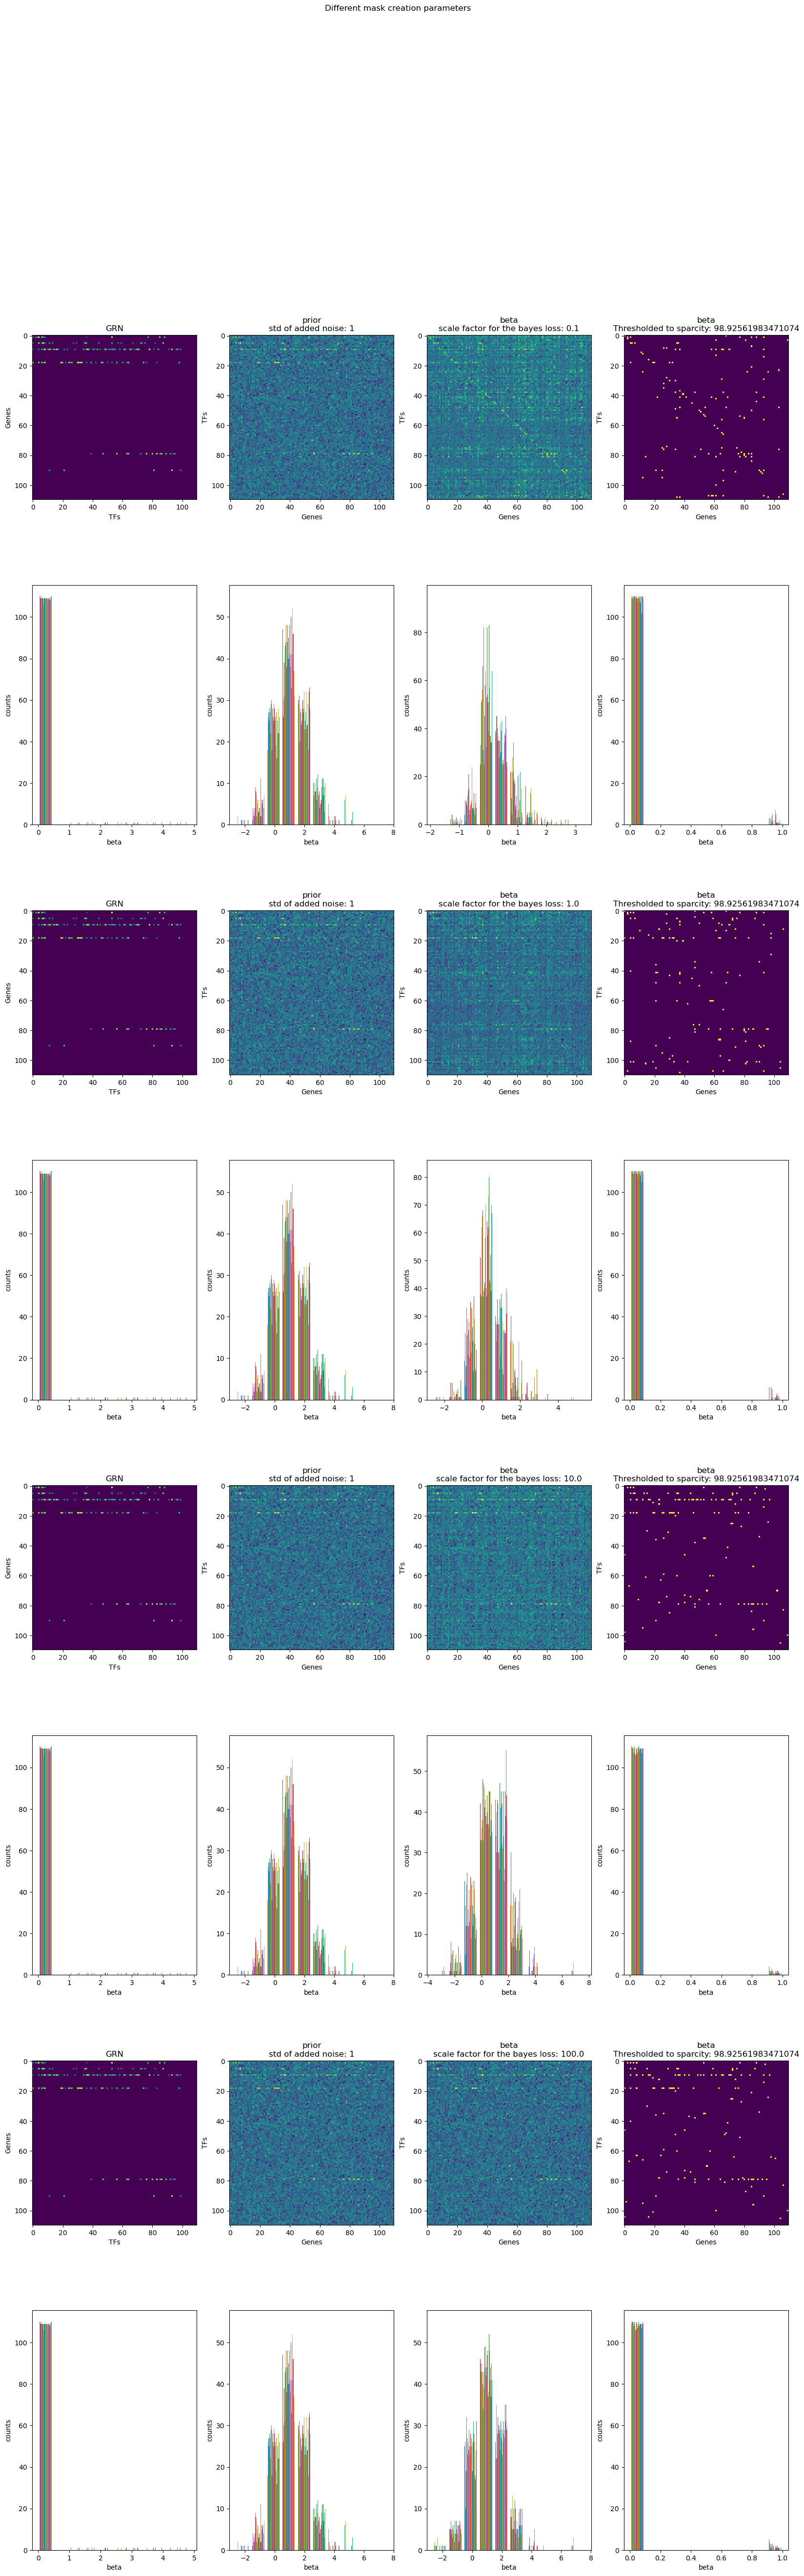

In [ ]:

fig, ax = plt.subplots(nrows=2 *len(params), ncols=4, figsize=(20, 60))
for n, key in enumerate(params.index):
    ax[0+n*2, 0].imshow(ckpts[key]["grn"])

    ax[0+n*2, 0].set_title("GRN")
    ax[0+n*2, 0].set_xlabel("TFs")
    ax[0+n*2, 0].set_ylabel("Genes")
    ax[0+n*2, 0].set_title("GRN")
    ax[1+n*2, 0].hist(ckpts[key]["grn"])
    ax[1+n*2, 0].set_xlabel("beta")
    ax[1+n*2, 0].set_ylabel("counts")

    ax[0+n*2, 1].imshow(ckpts[key]["prior"])
    ax[0+n*2, 1].set_ylabel("TFs")
    ax[0+n*2, 1].set_xlabel("Genes")
    ax[0+n*2, 1].set_title("prior\nstd of added noise: "+str(params.loc[key, "grn_noise"]))
    ax[1+n*2, 1].hist(ckpts[key]["prior"])
    ax[1+n*2, 1].set_xlabel("beta")
    ax[1+n*2, 1].set_ylabel("counts")

    ax[0+n*2, 2].imshow(ckpts[key]["beta"])
    ax[0+n*2, 2].set_ylabel("TFs")
    ax[0+n*2, 2].set_xlabel("Genes")
    ax[0+n*2, 2].set_title("beta\nscale factor for the bayes loss: "+str(params.loc[key, "scale_mask"]))
    ax[1+n*2, 2].hist(ckpts[key]["beta"])
    ax[1+n*2, 2].set_xlabel("beta")
    ax[1+n*2, 2].set_ylabel("counts")

    threshold = 100-get_sparsity(ckpts[key]["grn"])*100
    mtx=above_threshold(np.array(ckpts[key]["beta"]), percentile=threshold)
    ax[0+n*2, 3].imshow(mtx)
    ax[0+n*2, 3].set_ylabel("TFs")
    ax[0+n*2, 3].set_xlabel("Genes")
    ax[0+n*2, 3].set_title("beta\nThresholded to sparcity: " + str(threshold))
    ax[1+n*2, 3].hist(mtx)
    ax[1+n*2, 3].set_xlabel("beta")
    ax[1+n*2, 3].set_ylabel("counts")


fig.suptitle("Different mask creation parameters")
#fig.tight_layout()
fig.show()
#fig.savefig("./presentation/scalemask_beta_tableau.pdf")